In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm # to create progress bar

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
sns.set()    # Adjust the graphs

In [4]:
df = yf.download('AAPL', start= '2021-01-01', auto_adjust = True)

[*********************100%***********************]  1 of 1 completed


In [21]:
df.tail()

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2025-09-12,234.070007,234.509995,229.020004,229.220001,55824200
2025-09-15,236.699997,238.190002,235.029999,237.000000,42699500
2025-09-16,238.149994,241.220001,236.320007,237.179993,63421100
2025-09-17,238.990005,240.100006,237.729996,238.970001,46508000
2025-09-18,237.880005,241.199997,236.649994,239.970001,44219200


In [6]:
# Getting data ready

number_simulations = 100
predict_days = 300

# 1) Extract closing prices for the model 
prices = df['Close']

# 2) Compute daily returns(% change of price from one day to next)
returns = prices.pct_change().dropna()

# 3) Pull last Single value price from the series of prices
last_price = prices.iloc[-1]

# 4) Compute statistics

# avg daily return
avg_daily_ret = returns.mean()           

# daily volatility (how much the price jumps around)
daily_vol = returns.std()                

# 5) implementing the formula to calculate the drift (average expected direction of the stock price over time)
drift = avg_daily_ret - 0.5 * daily_vol**2

In [7]:
# creating a table to store the results
results = pd.DataFrame(index=range(predict_days + 1),
                       columns=range(number_simulations),
                       dtype=float)

# Running the simulation
for i in tqdm(range(number_simulations), desc="MC simulations"):
    # initialize path
    prices = [last_price]

    for _ in range(predict_days):
        # single-step shock, scalar
        shock = drift + daily_vol * np.random.normal()
        next_price = prices[-1] * np.exp(shock)
        prices.append(next_price)

    # assign the full path to column i
    results[i] = prices

MC simulations: 100%|████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.83it/s]


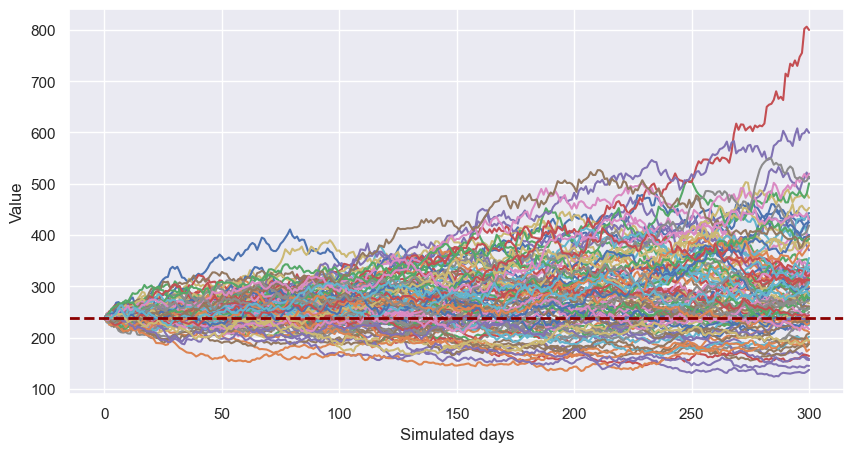

In [8]:
# Plotting the 100 predicted price on the graph for a period of 300 days
plt.figure(figsize=(10,5))
plt.plot(results)
plt.axhline(color = "#8B0000", linestyle = "dashed", y = last_price[0], linewidth = 2)
plt.ylabel('Value')
plt.xlabel('Simulated days')
plt.show()


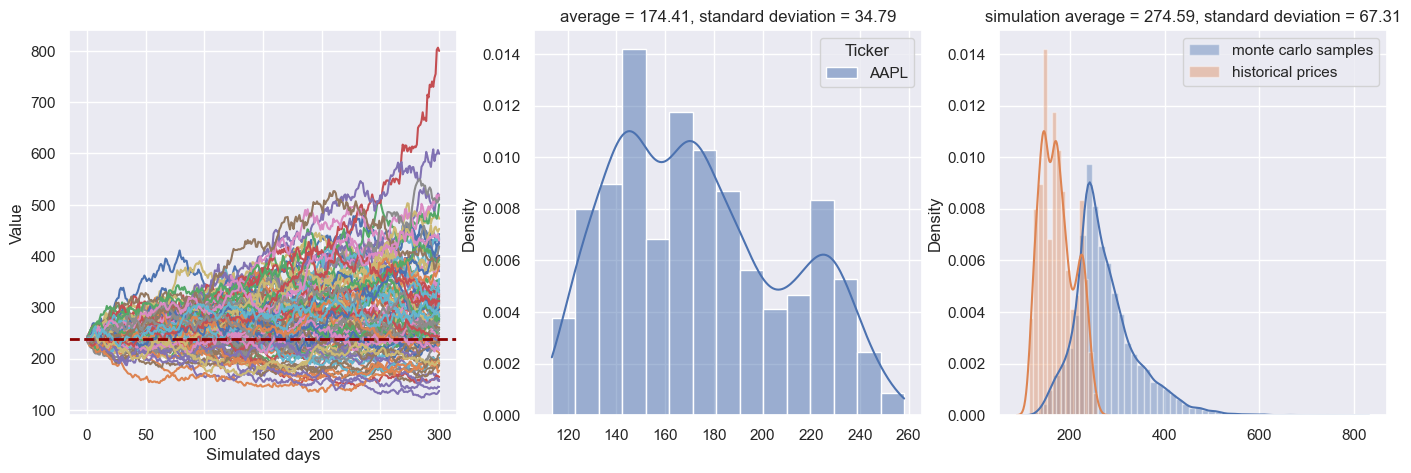

In [34]:
# Comparing the results to the historic data

# putting the outcome of 100 simulation in a list
raveled = np.array(results.values.ravel(), dtype=float)

plt.figure(figsize=(17,5))
plt.subplot(1,3,1)
plt.plot(results)
plt.axhline(color = "#8B0000", linestyle = "dashed", y = last_price[0], linewidth = 2)
plt.ylabel('Value')
plt.xlabel('Simulated days')

plt.subplot(1,3,2)
sns.histplot(df.Close, stat='density', kde=True)
plt.title('average = %.2f, standard deviation = %.2f' % (df.Close.mean(), df.Close.std()))

float(df.Close.mean())
float(df.Close.std())

plt.subplot(1,3,3)
sns.distplot(raveled, norm_hist=True, label='monte carlo samples')
sns.distplot(df.Close, norm_hist=True, label='historical prices')
plt.title('simulation average = %.2f, standard deviation = %.2f' % (raveled.mean(), raveled.std()))
plt.legend()
plt.show()
